In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import heapq
from PIL import Image
import math

class HuffmanNode:
    def __init__(self, value=None, freq=None):
        self.value = value
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

def calculate_histogram(image):
    """Calculate the histogram (probability distribution) of pixel intensities."""
    hist = defaultdict(int)
    total_pixels = image.size

    # Count frequency of each pixel value
    for pixel in image.flatten():
        hist[pixel] += 1

    # Convert frequencies to probabilities
    probabilities = {pixel: count/total_pixels for pixel, count in hist.items()}
    return dict(sorted(probabilities.items()))

def calculate_entropy(probabilities):
    """Calculate the entropy of the image in bits/symbol."""
    return -sum(p * math.log2(p) for p in probabilities.values())

def build_huffman_tree(probabilities):
    """Build a Huffman tree from probability distribution."""
    # Handle the special case of only one symbol
    if len(probabilities) == 1:
        value, freq = next(iter(probabilities.items()))
        node = HuffmanNode(value, freq)
        # For single symbol, we use 1 bit to encode it
        return node

    heap = []

    # Create leaf nodes for each symbol
    for value, freq in probabilities.items():
        heapq.heappush(heap, HuffmanNode(value, freq))

    # Build the tree
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)

        internal_node = HuffmanNode(freq=left.freq + right.freq)
        internal_node.left = left
        internal_node.right = right

        heapq.heappush(heap, internal_node)

    return heap[0]

def generate_huffman_codes(node, code="", codes=None):
    """Generate Huffman codes for each symbol."""
    if codes is None:
        codes = {}

    if node.value is not None:
        # For single symbol case, use '0' as the code
        codes[node.value] = code if code else '0'
    else:
        generate_huffman_codes(node.left, code + "0", codes)
        generate_huffman_codes(node.right, code + "1", codes)

    return codes

def calculate_average_code_length(probabilities, huffman_codes):
    """Calculate the average code length of the Huffman coding."""
    # Handle special case of one symbol
    if len(probabilities) == 1:
        return 1.0  # Use 1 bit for single symbol case

    return sum(probabilities[symbol] * len(code) for symbol, code in huffman_codes.items())

def analyze_image_compression(image_path):
    """Perform complete analysis of image compression using Huffman coding."""
    # Read image
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img_array = np.array(img)

    # Calculate histogram/probabilities
    probabilities = calculate_histogram(img_array)

    # Calculate entropy
    entropy = calculate_entropy(probabilities)

    # Build Huffman tree and generate codes
    huffman_tree = build_huffman_tree(probabilities)
    huffman_codes = generate_huffman_codes(huffman_tree)

    # Calculate average code length
    avg_code_length = calculate_average_code_length(probabilities, huffman_codes)

    # Calculate compression ratio and redundancy
    original_bits = 8  # Assuming 8-bit grayscale image
    compression_ratio = original_bits / avg_code_length
    redundancy = avg_code_length - entropy

    # Plotting
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(131)
    plt.imshow(img_array, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Histogram
    plt.subplot(132)
    plt.bar(probabilities.keys(), probabilities.values())
    plt.title('Intensity Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Probability')

    # Code length distribution
    plt.subplot(133)
    code_lengths = [len(code) for code in huffman_codes.values()]
    plt.hist(code_lengths, bins=max(code_lengths)-min(code_lengths)+1,
             range=(min(code_lengths)-0.5, max(code_lengths)+0.5))
    plt.title('Huffman Code Length Distribution')
    plt.xlabel('Code Length (bits)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Print analysis results with explanations
    print(f"\nCompression Analysis Results:")
    print(f"Number of unique values: {len(probabilities)}")
    if len(probabilities) == 1:
        print("Note: This image contains only one unique value!")
        print("In theory, we need 0 bits for encoding since there's no uncertainty,")
        print("but we use 1 bit practically for implementation purposes.")

    print(f"\nEntropy: {entropy:.2f} bits/symbol")
    print(f"Average Code Length: {avg_code_length:.2f} bits/symbol")
    print(f"Compression Ratio: {compression_ratio:.2f}:1")
    print(f"Redundancy: {redundancy:.2f} bits/symbol")

    # Print Huffman codes for educational purposes
    print("\nHuffman Codes:")
    for value, code in sorted(huffman_codes.items()):
        prob = probabilities[value]
        print(f"Value {value}: {code} (probability: {prob:.3f})")

    return probabilities, huffman_codes, entropy, compression_ratio, redundancy

def analyze_all_test_images(test_images):
    """Analyze all test images and compare their compression results."""
    results = {}

    for name, img in test_images.items():
        print(f"\nAnalyzing {name} image:")
        # Save temporary image for analysis
        Image.fromarray(img).save('temp.png')
        # Run analysis and store results
        results[name] = analyze_image_compression('temp.png')

    return results

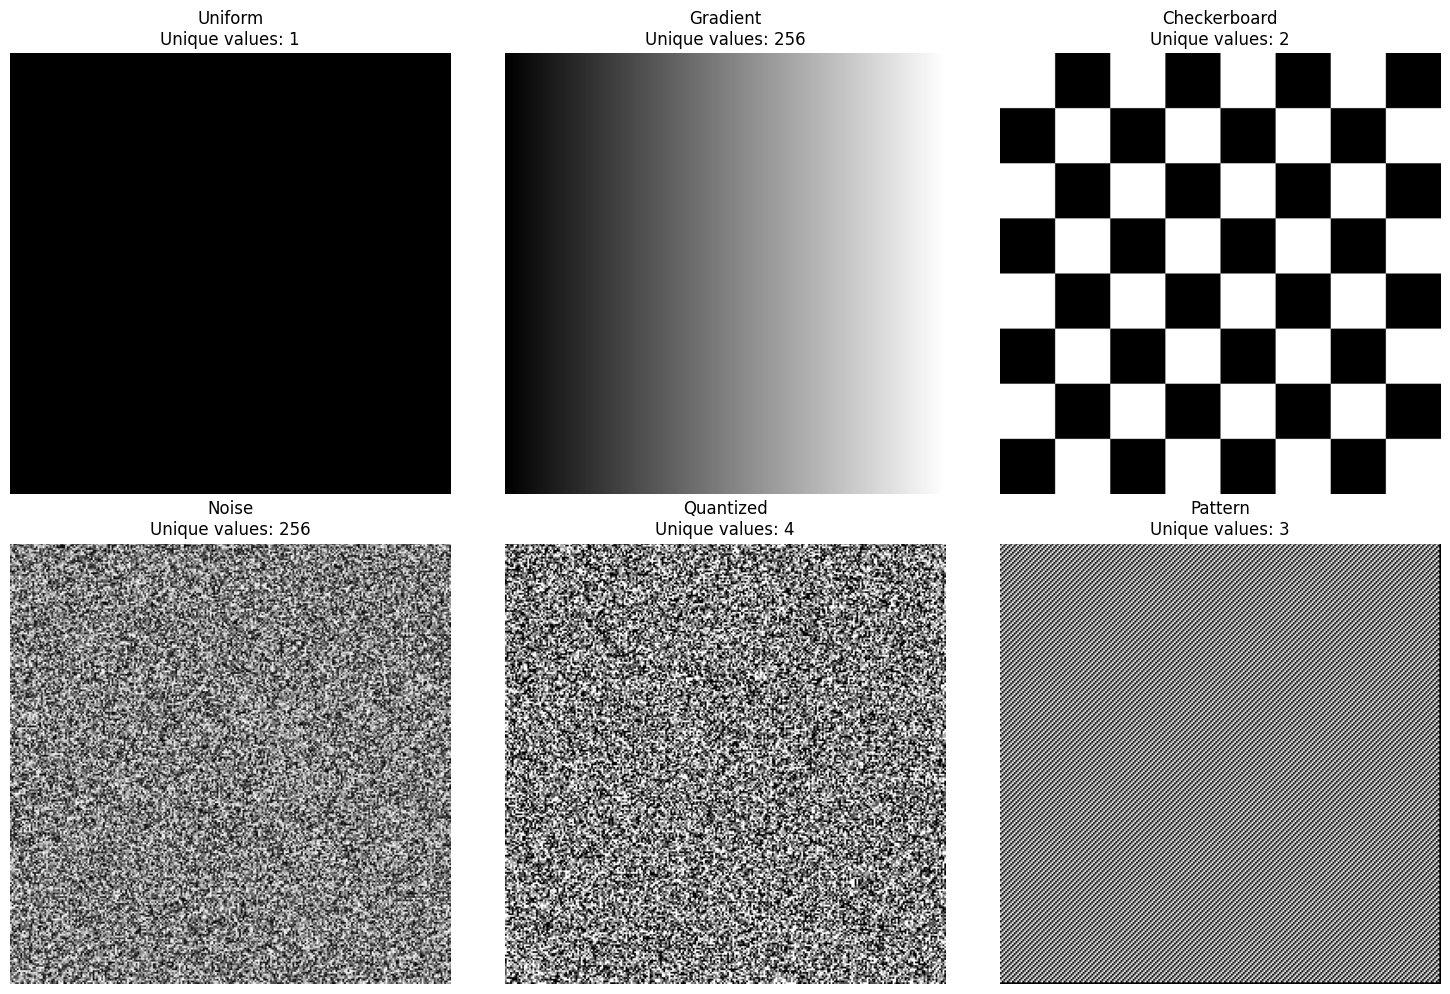


Test Image Characteristics:

Uniform:
- Unique intensity values: 1
- Mean intensity: 128.00
- Standard deviation: 0.00

Gradient:
- Unique intensity values: 256
- Mean intensity: 127.50
- Standard deviation: 73.90

Checkerboard:
- Unique intensity values: 2
- Mean intensity: 127.50
- Standard deviation: 127.50

Noise:
- Unique intensity values: 256
- Mean intensity: 127.28
- Standard deviation: 73.91

Quantized:
- Unique intensity values: 4
- Mean intensity: 127.41
- Standard deviation: 95.09

Pattern:
- Unique intensity values: 3
- Mean intensity: 126.67
- Standard deviation: 104.30


In [6]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

def create_test_images(size=(256, 256)):
    """
    Creates a set of test images specifically designed for demonstrating image compression concepts.
    Each image highlights different aspects of entropy and compression potential.

    Parameters:
        size (tuple): Desired size of the test images as (height, width)

    Returns:
        dict: Dictionary containing the generated test images
    """
    # Create uniform image (lowest entropy)
    uniform = np.ones(size, dtype=np.uint8) * 128

    # Create horizontal gradient (medium entropy)
    gradient_h = np.linspace(0, 255, size[1], dtype=np.uint8)
    gradient_h = np.tile(gradient_h, (size[0], 1))

    # Create checkerboard pattern (high local contrast, medium entropy)
    checkerboard = np.zeros(size, dtype=np.uint8)
    tile_size = 32
    for i in range(0, size[0], tile_size):
        for j in range(0, size[1], tile_size):
            if (i//tile_size + j//tile_size) % 2 == 0:
                checkerboard[i:i+tile_size, j:j+tile_size] = 255

    # Create random noise image (highest entropy)
    noise = np.random.randint(0, 256, size=size, dtype=np.uint8)

    # Create quantized image (few unique values, good for Huffman)
    levels = 4
    quantized = np.linspace(0, 255, levels, dtype=np.uint8)
    random_indices = np.random.randint(0, levels, size=size)
    quantized_image = quantized[random_indices]

    # Create repeating pattern (very compressible)
    pattern = np.zeros(size, dtype=np.uint8)
    basic_pattern = np.array([[0, 128, 255],
                             [128, 255, 0],
                             [255, 0, 128]], dtype=np.uint8)

    # Correctly tile the basic pattern across the entire image
    pattern_height, pattern_width = basic_pattern.shape
    for i in range(0, size[0] - pattern_height + 1, pattern_height):
        for j in range(0, size[1] - pattern_width + 1, pattern_width):
            pattern[i:i+pattern_height, j:j+pattern_width] = basic_pattern

    # Store all images in a dictionary
    test_images = {
        'uniform': uniform,
        'gradient': gradient_h,
        'checkerboard': checkerboard,
        'noise': noise,
        'quantized': quantized_image,
        'pattern': pattern
    }

    return test_images

def save_test_images(images, base_path='test_images'):
    """
    Saves the generated test images and creates a visualization grid.

    Parameters:
        images (dict): Dictionary containing the test images
        base_path (str): Base path for saving the images
    """
    # Ensure the output directory exists
    os.makedirs(os.path.dirname(base_path) if os.path.dirname(base_path) else '.', exist_ok=True)

    # Create figure for visualization
    plt.figure(figsize=(15, 10))

    for idx, (name, img) in enumerate(images.items(), 1):
        # Save individual image
        Image.fromarray(img).save(f'{base_path}_{name}.png')

        # Add to visualization grid
        plt.subplot(2, 3, idx)
        plt.imshow(img, cmap='gray')
        plt.title(f'{name.capitalize()}\nUnique values: {len(np.unique(img))}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print characteristics of each image
    print("\nTest Image Characteristics:")
    for name, img in images.items():
        unique_values = len(np.unique(img))
        mean_val = np.mean(img)
        std_val = np.std(img)
        print(f"\n{name.capitalize()}:")
        print(f"- Unique intensity values: {unique_values}")
        print(f"- Mean intensity: {mean_val:.2f}")
        print(f"- Standard deviation: {std_val:.2f}")

# Generate and save the test images
try:
    test_images = create_test_images()
    save_test_images(test_images)
except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("Please ensure you have write permissions in the current directory.")

In [7]:
# Run Huffman analysis on each test image
for name, img in test_images.items():
    print(f"\nAnalyzing {name} image:")
    # Save temporary image for analysis
    Image.fromarray(img).save('temp.png')
    # Run analysis
    analyze_image_compression('temp.png')

Output hidden; open in https://colab.research.google.com to view.